## Notebook for neural networks training and experiments

For the purposes of bachelor thesis of Jan Lubojacký, Software application for real time analysis of ECG signal on AI chip, 2022 at CTU FEL

Installs the necessary modules and known working versions of some libraries, other versions caused some troubles.

In [2]:
!pip install pandas==1.3.5
!pip install pickle5
!pip install tensorflow==2.7
!pip install neurokit2
!pip install -q tensorflow-model-optimization
# this requires the mobilenet.py to be placed in google drive
# at the specified path, alternatively it can be uploaded directly
# into the session
!cp /content/drive/MyDrive/bakalarka/mobilenet.py . 

     |████████████████████████████████| 256 kB 5.3 MB/s 
     |████████████████████████████████| 489.6 MB 24 kB/s 
     |████████████████████████████████| 463 kB 34.1 MB/s 
     |████████████████████████████████| 1.3 MB 48.5 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.0
    Uninstalling tensorflow-2.8.0:
      Successfully uninstalled tensorflow-2.8.0


     |████████████████████████████████| 1.1 MB 5.1 MB/s 
     |████████████████████████████████| 237 kB 5.1 MB/s 


**Imports the necessary modules**

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow
import tensorflow_hub as hub
import numpy as np
import math
import keras
from keras.models import Sequential
from keras.layers import Conv1D, Dropout, MaxPooling1D, Flatten, Dense, GlobalAveragePooling1D, SeparableConv1D
from keras.layers import BatchNormalization, Normalization, Activation, GlobalMaxPooling1D
from keras.layers.pooling import AveragePooling1D
from sklearn.utils import shuffle
import pickle5 as pickle
import pandas as pd
from keras.callbacks import ModelCheckpoint, CSVLogger
import os
import tensorflow_model_optimization as tfmot
import mobilenet
import neurokit2 as nk
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sn
from pprint import pprint

# pandas 1.3.x recommended, lower version does not support the protocol
# needed to unpickle the files
# I use tf version 2.7, because 2.8 caused issues with quantization

print(tf.__version__)
print(pd.__version__)

2.8.0
1.3.5


**Load datasets and preprocess**

In [ ]:
data = pd.DataFrame()

datasets_path = os.path.join('drive','MyDrive','bakalarka','datasets','5s_500Hz_Falsefilt_new')
datasets = os.listdir(datasets_path)
print(datasets)

def equalize_classes(data, random_state):
  print("EQUALIZING CLASSES")

  unique, counts = np.unique(data['label'], return_counts=True)
  print('unbalanced: ', dict(zip(unique, counts)))

  data_negative_class = data.loc[data['label'] == 0]
  data_positive_class = data.loc[data['label'] == 1]

  if len(data_positive_class) > len(data_negative_class):
    data_positive_class = data_positive_class.sample(n = len(data_negative_class), random_state = random_state)
  elif len(data_positive_class) < len(data_negative_class):
    data_negative_class = data_negative_class.sample(n = len(data_positive_class), random_state = random_state)
    
  data = pd.concat([data_negative_class, data_positive_class], ignore_index=True)

  unique, counts = np.unique(data['label'], return_counts=True)
  print('balanced: ', dict(zip(unique, counts)))

  return data

def scale_data(data):

  print("SCALING DATA")
  
  for i in range(len(data['ECG'])):
    arr = data['ECG'][i]

    arr = (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

    data.at[i, 'ECG'] = arr

  return data

def standardize_data(data):

  print("STANDARDIZING DATA")

  for i in range(len(data['ECG'])):
      
    arr = data['ECG'][i]

    arr = (arr - np.mean(arr) / np.std(arr))

    data.at[i, 'ECG'] = arr

  return data


'''
load datasets
'''

for dataset in datasets:
  # uncommenting the coresponidng line excludes the dataset from the training data

  # if "CLAS" in dataset: continue
  # if "WESAD" in dataset: continue
  # if "BIOMECH" in dataset: continue
  dataset_path = os.path.join(datasets_path,dataset)

  with open(dataset_path, 'rb') as handle:
    data_part = pickle.load(handle)
    data = pd.concat([data,data_part], ignore_index=True)

    print(dataset, type(data_part))

'''
data inspection
'''

# scale data, it is here because I wanted to have the ability
# to experiment with unnormalized/normalized data and this way
# there is no need to create extra datasets for it

data = equalize_classes(data, random_state = 22) # handle class imbalances

# data = standardize_data(data) # or standardize the data

data_path = os.path.join('drive','MyDrive','bakalarka','datasets','ecg_folder.pkl')

with open(data_path, 'rb') as handle:
    ecg_data = pickle.load(handle)

ecg_data = ecg_data.to_numpy()
ecg_data = ecg_data.flatten()
ecg_data = np.array_split(ecg_data,7992)
data['ECG'] = ecg_data

print(data)

'''
Ratios
'''
train_ratio = 0.6
val_ratio = 0.2     # Percentage of samples that should be held for validation set
test_ratio = 1 - (train_ratio + val_ratio) # Percentage of samples that should be held for test set

'''
Train, val, test splits
'''

train, val, test = \
              np.split(data.sample(frac=1, random_state=24), 
                       [int(train_ratio*len(data)), int((1-val_ratio)*len(data))])
              
x_train = np.stack(train['ECG'].values, axis=0)
y_train = np.stack(train['label'].values, axis=0)

x_val = np.stack(val['ECG'].values, axis=0)
y_val = np.stack(val['label'].values, axis=0)

x_test = np.stack(test['ECG'].values, axis=0)
y_test = np.stack(test['label'].values, axis=0)

df_test = {
    'ECG' : x_test,
    'label' : y_test
}

with open(''+'test_data.pkl', 'wb') as handle:
    pickle.dump(df_test, handle, protocol=4)

# validate, that there is aprox. equal amount of each class in each split
unique, counts = np.unique(train['label'], return_counts=True)
print('train classes')
print(dict(zip(unique, counts)))

unique, counts = np.unique(val['label'], return_counts=True)
print('val classes')
print(dict(zip(unique, counts)))

unique, counts = np.unique(test['label'], return_counts=True)
print('test classes')
print(dict(zip(unique, counts)))

# input length for neural networks
input_length = data['ECG'][0].size

print('input_length', input_length)

['BIOMECH_5s_500Hz_prepro_False.pkl', 'WESAD_5s_500Hz_prepro_False.pkl', 'CLAS_5s_500Hz_prepro_False.pkl']
BIOMECH_5s_500Hz_prepro_False.pkl <class 'pandas.core.frame.DataFrame'>
WESAD_5s_500Hz_prepro_False.pkl <class 'pandas.core.frame.DataFrame'>
CLAS_5s_500Hz_prepro_False.pkl <class 'pandas.core.frame.DataFrame'>
EQUALIZING CLASSES
unbalanced:  {0: 3996, 1: 5270}
balanced:  {0: 3996, 1: 3996}
                                                    ECG  label
0     [0.521962, 0.535427, 0.601648, 0.623433, 0.546...      0
1     [0.492684, 0.476485, 0.392296, 0.343058, 0.398...      0
2     [0.497291, 0.512911, 0.60925, 0.711345, 0.6837...      0
3     [0.501066, 0.491496, 0.438298, 0.397938, 0.423...      0
4     [0.517815, 0.511725, 0.479121, 0.462063, 0.491...      0
...                                                 ...    ...
7987  [0.33393, 0.366622, 0.515114, 0.566868, 0.5969...      1
7988  [0.488592, 0.544558, 0.840425, 0.990878, 0.760...      1
7989  [0.480942, 0.469744, 0.41071

**Cross validation for optimal treshold, and also comparison between the tresholding method and a more advanced one**

optimal treshold is aproximately 0.677 for neurokit preprocessing
and 0.713 for microcontroller preprocessing

The cell takes about a 1m20s to run, the neurokit R peak detection is very slow compared to the tresholding method

In [ ]:
#@title Testing R peak detection
import matplotlib.pyplot as plt

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def heart_rate(mean_rr_interval, sampling_rate):
  return 60 * (sampling_rate / mean_rr_interval)

def mean_rr_interval(peaks_sample_num):
  return np.mean(np.diff(peaks_sample_num))

def get_signal_parameters_nk(x,y):
  parameters_x = []
  parameters_y = []
  errors = 0

  for i in range(len(x)):
    signal = x[i]

    signals, info = nk.ecg_peaks(signal, correct_artifacts=True, method = 'neurokit', sampling_rate = 100)

    unique, counts = np.unique(signals['ECG_R_Peaks'].values, return_counts=True)

    peaks_sample_number = np.where(signals['ECG_R_Peaks'].values==1)[0]

    mean_rr = mean_rr_interval(peaks_sample_number)
    hr = heart_rate(mean_rr, 100)

    parameters_x.append(peaks_sample_number)
    parameters_y.append(hr)

  return np.array(parameters_x), np.array(parameters_y)


def get_signal_parameters(x, y, repolarization_window=40, treshold=0.677):

  parameters_x = []
  parameters_y = []
  errors = 0

  for i in range(len(x)):
    signal = x[i]
    label = y[i]

    peaks = np.zeros_like(signal)

    peaks_sample_number = []
    peak_count = 0
    last_signal_peak = False
    repolarization = False
    repolarization_count = repolarization_window

    for i in range(len(signal)):

      if repolarization == True:
        repolarization_count -= 1

        if repolarization_count == 0:
          repolarization = False
          repolarization_count = repolarization_window

      elif repolarization == False:

        if signal[i] > treshold and last_signal_peak == False:
          last_signal_peak = True
          peaks[i] = 1
          peak_count += 1
          peaks_sample_number.append(i)
          repolarization = True
        else:
          last_signal_peak = False

    mean_rr = mean_rr_interval(peaks_sample_number)
    hr = heart_rate(mean_rr, 100)

    parameters_x.append(peaks_sample_number)
    parameters_y.append(hr)

  return np.array(parameters_x), np.array(parameters_y)

tresholds = np.linspace(0.6, 0.9, num=30)

repolariztaion_window = np.arange(30, 60, 1)

cross_val_array = tresholds # or repolariztaion_window

positions_nk, hr_nk = get_signal_parameters_nk(x_train, y_train)

for win in cross_val_array:

  positions_treshold, hr_treshold = get_signal_parameters(x_train, y_train, treshold=win)

  bigger_diff = 0
  correct = 0
  one_beat_diff = 0
  two_beat_diff = 0

  print(len(hr_nk), len(hr_treshold))

  difference = abs(hr_nk - hr_treshold)
  tr = np.where(difference <= 5)[0]

  print(len(tr))

  print(len(positions_treshold))

  for i in range(len(positions_treshold)):
    if len(positions_treshold[i]) == len(positions_nk[i]):

      differences = abs(positions_treshold[i] - positions_nk[i])

      if differences.all() < 5:
        correct += 1

      # if correct % 2000 == 0:
      #   x_values = np.linspace(start=0,stop=5,num=500)
      #   plt.figure(1, figsize=(15, 10), dpi=80)
      #   plt.plot(x_values, x_train[i])
      #   peaks_det = np.take(x_values, positions_treshold[i])
      #   plt.plot(peaks_det, np.ones_like(peaks_det), 'bo', color='red')
      #   peaks_det_nk = np.take(x_values, positions_nk[i])
      #   plt.plot(peaks_det_nk, np.ones_like(peaks_det_nk), 'bo', color='green')
      #   plt.xlabel("time[s]")
      #   plt.ylabel("ECG [-]")

    elif len(positions_treshold[i]) - 1 == len(positions_nk[i]):

      pos1 = abs(positions_treshold[i][:-1] - positions_nk[i])
      pos2 = abs(positions_treshold[i][1:] - positions_nk[i])

      if (pos1.all() < 15):
        one_beat_diff += 1
      elif (pos2.all() < 15):
        one_beat_diff += 1

    elif len(positions_nk[i]) - 1 == len(positions_treshold[i]):

      pos1 = abs(positions_nk[i][:-1] - positions_treshold[i])
      pos2 = abs(positions_nk[i][1:] - positions_treshold[i])

      if (pos1.all() < 15):
        one_beat_diff += 1
      elif (pos2.all() < 15):
        one_beat_diff += 1

    elif len(positions_treshold[i]) - 2 == len(positions_nk[i]):

      pos1 = abs(positions_treshold[i][1:-1] - positions_nk[i])

      if (pos1.all() < 15):
        two_beat_diff += 1

    else:
      bigger_diff += 1

      # if bigger_diff % 50 == 0:
      #   x_values = np.linspace(start=0,stop=5,num=500)
      #   plt.figure(1, figsize=(15, 10), dpi=80)
      #   plt.plot(x_values, x_train[i])
      #   peaks_det = np.take(x_values, positions_treshold[i])
      #   plt.plot(peaks_det, np.ones_like(peaks_det), 'bo', color='red')
      #   peaks_det_nk = np.take(x_values, positions_nk[i])
      #   plt.plot(peaks_det_nk, np.ones_like(peaks_det_nk), 'bo', color='green')
      #   plt.xlabel("time[s]")
      #   plt.ylabel("ECG [-]")

  print('treshold', win, 'correct', correct, 'one_beat_diff', one_beat_diff, 'two_beat_diff', two_beat_diff, 'bigger_diff', bigger_diff)

**Models declarations**

In [ ]:
def Parameters_model():
  model = Sequential()

  model.add(tf.keras.Input(shape=(4,)))

  model.add(Dense(20, activation = 'relu'))
  model.add(Dropout(0.3))

  model.add(Dense(20, activation = 'relu'))
  model.add(Dropout(0.3))

  model.add(Dense(20, activation = 'relu'))
  model.add(Dropout(0.3))

  model.add(Dense(1, activation = 'sigmoid'))

  model._name = "Parameters_model"

  return model

def Custom_model(input_length):
    model = Sequential()
    model.add(
        Conv1D(filters=8,
               kernel_size=32,
               strides=3,
               input_shape=(input_length, 1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3, strides=1))

    model.add(SeparableConv1D(filters=16, kernel_size=24, strides=2))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(AveragePooling1D(pool_size=3, strides=1))

    model.add(SeparableConv1D(filters=32, kernel_size=16, strides=1))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(AveragePooling1D(pool_size=2, strides=1))

    model.add(SeparableConv1D(filters=64, kernel_size=4, strides=1))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(AveragePooling1D(pool_size=2, strides=1))
    
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model._name = "Custom_model"

    return model

def model_output(x, pooling, dropout_rate): 
  x = GlobalAveragePooling1D()(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dropout(dropout_rate)(x)
  outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

  return outputs

def MobileNetv3modded(input_lenght, alpha, num_channel=1):
  inputs = keras.Input(shape = (input_length,1))

  x = mobilenet.Conv_1D_block_2(inputs, 8, 3, strides=2, nl='HS')

  x = mobilenet.bottleneck_block_2(x, 8, 3, e=8, s=2, squeeze=True, nl='RE', alpha=alpha)
  x = mobilenet.bottleneck_block_2(x, 10, 3, e=16, s=2, squeeze=False, nl='HS', alpha=alpha)
  x = mobilenet.bottleneck_block_2(x, 10, 3, e=32, s=1, squeeze=False, nl='HS', alpha=alpha)
  x = mobilenet.bottleneck_block_2(x, 12, 5, e=64, s=1, squeeze=True, nl='HS', alpha=alpha)

  x = mobilenet.Conv_1D_block_2(x, 5, 1, strides=1, nl='HS')
  x = x * tf.keras.activations.relu(x + 3.0, max_value=6.0) / 6.0
  x = tf.keras.layers.Conv1D(10, 1, padding='same')(x)

  outputs = model_output(x, pooling='avg', dropout_rate=0.1)
  model = tf.keras.Model(inputs, outputs)

  model._name = "MobileNetv3modded"

  return model

'''
By uncomenting, choose the desired model for training
'''

model = MobileNetv3modded(input_length, 1)
# model = Custom_model(input_length)
# model = Parameters_model()

model.summary()

Model: "MobileNetv3modded"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 500, 1)]     0           []                               
                                                                                                  
 conv1d_22 (Conv1D)             (None, 250, 8)       32          ['input_3[0][0]']                
                                                                                                  
 batch_normalization_28 (BatchN  (None, 250, 8)      32          ['conv1d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 tf.__operators__.add_18 (TFOpL  (None, 250, 8)      0           ['batch_normaliza

**lets find the optimal lr**

In [ ]:
EPOCHS = 100

model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

initial_history = model.fit(x_train,
                    y_train,
                    epochs=EPOCHS,
                    validation_data=(x_val, y_val),
                    callbacks=tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4*10 ** (epoch / 30)))


# Plot the training history
loss = initial_history.history['loss']
val_loss = initial_history.history['val_loss']

train_acc = initial_history.history['accuracy']
val_acc = initial_history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

**And lets plot the graphs from which we can determine what learning rate should we use**

In [ ]:
from matplotlib import rcParams

rcParams['figure.figsize'] = (20, 16)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False 


plt.figure(1)
plt.subplots_adjust(hspace = 0.5)
plt.subplot(4,2,1)
plt.plot(
    np.arange(1, 101), 
    initial_history.history['loss'], 
    label='Loss', lw=3
)
plt.plot(
    np.arange(1, 101), 
    initial_history.history['accuracy'], 
    label='Accuracy', lw=3
)
plt.plot(
    np.arange(1, 101), 
    initial_history.history['lr'], 
    label='Learning rate', color='#000', lw=3, linestyle='--')
plt.title('Evaluation metrics', size=16)
plt.xlabel('Epoch', size=14)
plt.legend();

plt.figure(1)
plt.subplot(4,2,2)
plt.plot(
    np.arange(1, 101), 
    initial_history.history['loss'], 
    label='Loss', lw=3
)
plt.plot(
    np.arange(1, 101), 
    initial_history.history['val_accuracy'], 
    label='Validation Accuracy', lw=3
)
plt.plot(
    np.arange(1, 101), 
    initial_history.history['lr'], 
    label='Learning rate', color='#000', lw=3, linestyle='--')
plt.title('Evaluation metrics', size=16)
plt.xlabel('Epoch', size=14)
plt.legend();

learning_rates = 1e-3 * (10 ** (np.arange(100) / 30))
plt.subplot(4,2,3)
plt.semilogx(
    learning_rates, 
    initial_history.history['loss'], 
    lw=3, color='#000'
)
plt.title('Learning rate vs. loss', size=16)
plt.xlabel('Learning rate', size=14)
plt.ylabel('Loss', size=14);
plt.subplot(4,2,4)
plt.semilogx(
    learning_rates, 
    initial_history.history['val_loss'], 
    lw=3, color='#000'
)
plt.title('Learning rate vs. val loss', size=16)
plt.xlabel('Learning rate', size=14)
plt.ylabel('Val loss', size=14);

**Training method for neural network, we can assign the chosen learning rate to the Adam optimizer. An early stopping callback is provided, this stop the training when the required accuracy on validation set is reached.**

In [ ]:
EPOCHS = 400
BATCH_SZ = 32
new_lr = 0.0022

class MyThresholdCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') >= 0.91:
            self.model.stop_training = True


# normal training
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

model.optimizer.lr.assign(new_lr)

# Train model
callbacks = [MyThresholdCallback()]

history = model.fit(x_train,
                    y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SZ,
                    validation_data=(x_val, y_val),
                    callbacks = callbacks)

# Plot the training history
loss = history.history['loss']
val_loss = history.history['val_loss']

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training loss', color='orange', lw=3)
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.plot(epochs, train_acc, 'b', label='Training accuracy', color='orange', lw=3)
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()


**This section runs the training with pruning callback**

In [ ]:
EPOCHS = 50
BATCH_SZ = 66
new_lr =  0.0005

# weigth pruning
pruned_model = tfmot.sparsity.keras.prune_low_magnitude(model)
callbacks = [ tfmot.sparsity.keras.UpdatePruningStep()]

pruned_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

pruned_model.optimizer.lr.assign(new_lr)

history = pruned_model.fit(x_train,
                    y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SZ,
                    validation_data=(x_val, y_val),
                    callbacks = callbacks)

model = tfmot.sparsity.keras.strip_pruning(pruned_model) 

# Plot the training history
loss = history.history['loss']
val_loss = history.history['val_loss']

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training loss', color='orange', lw=3)
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.plot(epochs, train_acc, 'b', label='Training accuracy', color='orange', lw=3)
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

**Evaluation section, here are implemented all the evaluation methods**

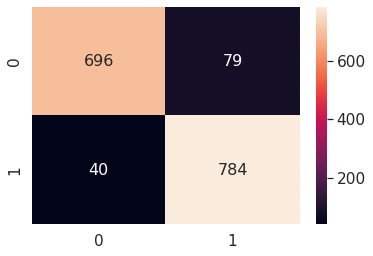

{'true_positives': 784, 'true_negatives': 696, 'false_positives': 79, 'false_negatives': 40, 'accuracy': 0.93, 'sensitivity': 0.95, 'specificity': 0.9, 'precision': 0.91, 'f1': 0.93}


In [ ]:
def get_evaluation_metrics(model, x_test, y_test):

    x_test = np.round(x_test, 6)
    # print(x_test)
    predictions = np.round(model.predict(x_test).flatten())

    tn = 0
    tp = 0
    fn = 0
    fp = 0

    cmtx = confusion_matrix(y_test, predictions)
    tn = cmtx[0][0]
    fp = cmtx[0][1]
    fn = cmtx[1][0]
    tp = cmtx[1][1]

    df_cm = pd.DataFrame(cmtx, range(2), range(2))
    # plt.figure(figsize=(10,7))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt = 'd') # font size

    plt.show()

    accuracy = (tn + tp) / (tn + tp + fn + fp)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)

    f1 = f1_score(y_test, predictions)

    eval_metrics = {
        'true_positives': tp,
        'true_negatives': tn,
        'false_positives': fp,
        'false_negatives': fn,
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision,
        'f1': f1
    }

    for key in eval_metrics:
        # rounding to K using round()
        eval_metrics[key] = round(eval_metrics[key], 2)

    print(eval_metrics)

def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for i, test_ecg in enumerate(x_test):
    # print(test_ecg)
    if i % 1000 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_ecg = test_ecg.reshape(1,1000,1)
    test_ecg = np.float32(test_ecg)
    # print(test_ecg)
    interpreter.set_tensor(input_index, test_ecg)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  print('\n')
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  accuracy = (prediction_digits == y_test).mean()
  return accuracy
  
get_evaluation_metrics(model, x_test, y_test)

**Here the model is converted with both the default conversion and the 8-bit quantization into a compressed tflite model**

In [ ]:
# Convert Keras model to a tflite model
# Dynamic range quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

tf_lite_default_opt = converter.convert()

# Save the quantized file
TFLITE_MODEL = 'mb3_100Hz_5s_ucfil_lowepoch' + 'uncompressed' + '.tflite'
open(TFLITE_MODEL, 'wb').write(tf_lite_default_opt)

# Convert Keras model to a tflite model
# Full integer quantization
def representative_dataset_gen():
  for data in x_val:
    sample = data.reshape(1,input_length,1)
    sample = [np.float32(sample)]
    yield sample

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.representative_dataset = representative_dataset_gen
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# For full integer quantization, though supported types defaults to int8 only
converter.target_spec.supported_types = [tf.int8]

# These set the input and output tensors to float32, uint8 could be used, 
# however that decreased the accuracy greatly
converter.inference_input_type = tf.float32  # or tf.int8/tf.float32
converter.inference_output_type = tf.float32  # or tf.int8/tf.float32

quant_model = converter.convert()

# Save the quantized file
TFLITE_QUANT_MODEL = 'mb3_100Hz_5s_ucfilt_lowepoch' + 'compressed' + '.tflite'
open(TFLITE_QUANT_MODEL, 'wb').write(quant_model)

INFO:tensorflow:Assets written to: /tmp/tmpk0lmvllt/assets


INFO:tensorflow:Assets written to: /tmp/tmpk0lmvllt/assets


INFO:tensorflow:Assets written to: /tmp/tmpjz2ssw9m/assets


INFO:tensorflow:Assets written to: /tmp/tmpjz2ssw9m/assets


61440

**Evaluation for both the compressed and uncompressed converted model to check whether the conversion decreased the models accuracy**

In [ ]:
def tf_lite_model_eval(model_path, x_test, y_test):

  print(model_path)

  tflite_interpreter = tf.lite.Interpreter(model_path=model_path)

  input_details = tflite_interpreter.get_input_details()
  output_details = tflite_interpreter.get_output_details()

  predictions = np.zeros(len(y_test))

  i = 0

  input_length = len(x_test[0])

  for ecg in x_test:
    ecg = ecg.reshape(1,input_length,1)
    ecg = np.float32(ecg)

    tflite_interpreter.allocate_tensors()
    tflite_interpreter.set_tensor(input_details[0]['index'], ecg)
    tflite_interpreter.invoke()
    tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])

    predictions[i] = tflite_model_predictions
    i+=1

  predictions = np.round(predictions)

  cmtx = confusion_matrix(y_test, predictions)
  tn = cmtx[0][0]
  fp = cmtx[0][1]
  fn = cmtx[1][0]
  tp = cmtx[1][1]

  df_cm = pd.DataFrame(cmtx, range(2), range(2))
  # plt.figure(figsize=(10,7))
  sn.set(font_scale=1.4) # for label size
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt = 'd') # font size

  plt.show()

  accuracy = (tn + tp) / (tn + tp + fn + fp)
  sensitivity = tp / (tp + fn)
  specificity = tn / (tn + fp)
  precision = tp / (tp + fp)

  f1 = f1_score(y_test, predictions)

  return {
      'true_positives': tp,
      'true_negatives': tn,
      'false_positives': fp,
      'false_negatives': fn,
      'accuracy': accuracy,
      'sensitivity': sensitivity,
      'specificity': specificity,
      'precision': precision,
      'f1': f1}

def load_fresh_dataset(dataset_path):
  
  datasets = os.listdir(datasets_path)

  compressed_test_data = pd.DataFrame()

  for dataset in datasets:

    # if "CLAS" in dataset: continue
    # if "WESAD" in dataset: continue
    # if "BIOMECH" in dataset: continue

    print((dataset))

    dataset_path = os.path.join(datasets_path,dataset)
    
    print(dataset_path)

    with open(dataset_path, 'rb') as handle:
      compressed_test_data_part = pickle.load(handle)

      compressed_test_data = pd.concat([compressed_test_data, compressed_test_data_part], ignore_index=True)


  compressed_test_data = scale_data(compressed_test_data)

  x_compressed_test = np.stack(compressed_test_data['ECG'].values, axis=0)
  y_compressed_test = np.stack(compressed_test_data['label'].values, axis=0)

  # optionaly select model
  # TFLITE_MODEL = '/content/drive/MyDrive/bakalarka/Tf_lite_models/cnn_100Hz_5s_94acc.tflite'
  # TFLITE_QUANT_MODEL = '/content/drive/MyDrive/bakalarka/Tf_lite_models/cnn_100Hz_5s_ucfilt.tflite'

  print(tf_lite_model_eval(TFLITE_MODEL, x_compressed_test, y_compressed_test))
  print(tf_lite_model_eval(TFLITE_QUANT_MODEL, x_compressed_test, y_compressed_test))


print(tf_lite_model_eval(TFLITE_MODEL, x_test, y_test))
print(tf_lite_model_eval(TFLITE_QUANT_MODEL, x_test, y_test))


BIOMECH_5s_100Hz_prepro_True.pkl
drive/MyDrive/bakalarka/datasets/5s_100Hz_Truefilt_new/BIOMECH_5s_100Hz_prepro_True.pkl
WESAD_5s_100Hz_prepro_True.pkl
drive/MyDrive/bakalarka/datasets/5s_100Hz_Truefilt_new/WESAD_5s_100Hz_prepro_True.pkl
CLAS_5s_100Hz_prepro_True.pkl
drive/MyDrive/bakalarka/datasets/5s_100Hz_Truefilt_new/CLAS_5s_100Hz_prepro_True.pkl
SCALING DATA
mb3_100Hz_5s_ucfil_lowepochuncompressed.tflite
{'true_positives': 3705, 'true_negatives': 996, 'false_positives': 3000, 'false_negatives': 146, 'accuracy': 0.599082451892443, 'sensitivity': 0.9620877694105427, 'specificity': 0.24924924924924924, 'precision': 0.5525727069351231, 'f1': 0.7019704433497538}
